In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
import pandas as pd

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

FileNotFoundError: [Errno 2] No such file or directory: './datasets/train.csv'

In [5]:
print(df.loc[0,'review'])

I know that Chill Wills usually played lovable old sorts in Westerns. But his role in this segment is something I've remembered for a long time. Wills could be a first rate villain. Yes, Burgess Meredith's Fall was correct! That look in Hepplewhite's eye! It expressed porcine greed, ignorance, and the threat of violence all at once. Quite a performance, I think.<br /><br />The segment itself was a good one, too. Question: couldn't the little black bag cure alcoholism? I guess it did, sort of, with Fall. But the doctor would have been wise to apply the cure, if he had it, as quickly as possible to Hepplewhite.<br /><br />There is one moment that was annoying but also necessary. And it is something that appears to recur in these Night Gallery segments. It's Serling's constant need to sermonize. For that's what we got, one more time, with Dr. Fall. I don't know what was more frustrating, losing the black bag and all its miracles or not being to stop Fall from preaching about the bag's ben

In [9]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [10]:
print(preprocessor(df.loc[0,'review']))

i know that chill wills usually played lovable old sorts in westerns but his role in this segment is something i ve remembered for a long time wills could be a first rate villain yes burgess meredith s fall was correct that look in hepplewhite s eye it expressed porcine greed ignorance and the threat of violence all at once quite a performance i think the segment itself was a good one too question couldn t the little black bag cure alcoholism i guess it did sort of with fall but the doctor would have been wise to apply the cure if he had it as quickly as possible to hepplewhite there is one moment that was annoying but also necessary and it is something that appears to recur in these night gallery segments it s serling s constant need to sermonize for that s what we got one more time with dr fall i don t know what was more frustrating losing the black bag and all its miracles or not being to stop fall from preaching about the bag s benefit for humanity all while rubbing hepplewhite s g

In [11]:
def tokenizer(text):
    return re.split('\s+', text.strip())

print(tokenizer('runners like running and thus they run'))

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']


In [12]:
from nltk.stem.porter import PorterStemmer

def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]

print(tokenizer_stem('runners like running and thus they run'))

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

print(tokenizer_stem_nostop('runners like running and thus they run'))

['runner', 'like', 'run', 'thu', 'run']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer

doc_dummy = ["Study hard, then you will be happy and I will be happy",
           "\"I'm not happy :(\" \", because you don't study hard"]
print('[example documents]\n{}\n'.format('\n'.join(doc_dummy)))

# ngram_range=(min,max), default: 1-gram => (1,1)
count = CountVectorizer(ngram_range=(1, 1),
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)

count.fit(doc_dummy)
# dictionary is stored in vocabulary_
BoW = count.vocabulary_
print('[vocabulary]\n{}'.format(BoW))

[example documents]
Study hard, then you will be happy and I will be happy
"I'm not happy :(" ", because you don't study hard

[vocabulary]
{'studi': 2, 'hard': 1, 'happi': 0}


In [15]:
# get matrix (doc_id, vocabulary_id) --> tf
doc_bag = count.transform(doc_dummy)
print('(did, vid)\ttf')
print(doc_bag)

print('\nIs document-term matrix a scipy.sparse matrix? {}'.format(sp.sparse.issparse(doc_bag)))

(did, vid)	tf
  (0, 0)	2
  (0, 1)	1
  (0, 2)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1

Is document-term matrix a scipy.sparse matrix? True


In [16]:
doc_bag = doc_bag.toarray()
print(doc_bag)

print('\nAfter calling .toarray(), is it a scipy.sparse matrix? {}'.format(sp.sparse.issparse(doc_bag)))

[[2 1 1]
 [1 1 1]]

After calling .toarray(), is it a scipy.sparse matrix? False


In [19]:
doc = df['review'].iloc[:100]
doc_bag = count.fit_transform(doc).toarray()

print("[most frequent vocabularies]")
bag_cnts = np.sum(doc_bag, axis=0)
top = 10
# [::-1] reverses a list since sort is in ascending order
for tok, v in zip(count.inverse_transform(np.ones((1, bag_cnts.shape[0])))[0][bag_cnts.argsort()[::-1][:top]], np.sort(bag_cnts)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[most frequent vocabularies]
film: 230
movi: 186
one: 113
like: 94
make: 69
good: 68
see: 64
watch: 59
time: 55
look: 55


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,1),
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(doc)

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))

doc_tfidf = tfidf.transform(doc).toarray()
tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[vocabularies with smallest idf scores]
film: 1.31
one: 1.47
movi: 1.49
like: 1.66
good: 1.85
see: 1.90
make: 1.90
time: 1.90
look: 1.95
realli: 2.00

[vocabularies with highest tf-idf scores]
film: 7.0669017094152355
movi: 6.2999668845578265
one: 3.435653149608354
like: 3.4259334935066805
good: 3.090884892382419
watch: 2.9145931936069243
see: 2.6096711446618777
make: 2.533831399982588
look: 2.303352832004743
go: 2.2474055126830565


In [22]:
print(doc_tfidf.shape)

(100, 3248)


In [23]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

print('[example documents]\n{}\n'.format('\n'.join(doc_dummy)))

# hash words to 1024 buckets
hashvec = HashingVectorizer(n_features=2**10,
                            preprocessor=preprocessor,
                            tokenizer=tokenizer_stem_nostop)

# no .fit needed for HashingVectorizer, since it's defined by the hash function

# transform sentences to vectors of dimension 1024
doc_hash = hashvec.transform(doc_dummy)
print(doc_hash.shape)

[example documents]
Study hard, then you will be happy and I will be happy
"I'm not happy :(" ", because you don't study hard

(2, 1024)


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

# randomly sample 1000 examples
df_small = df.sample(n=1000, random_state=0)

names = ['LogisticRegression',
         'LogisticRegression+(1,2)gram',
         'LogisticRegression+preprocess',
         'LogisticRegression+preprocess+hash']
# without preprocessing
pipe1 = Pipeline([('vect', CountVectorizer()),
                  ('clf', LogisticRegression(solver = "liblinear"))])
# without preprocessing, use larger ngram range
pipe2 = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                  ('clf', LogisticRegression(solver = "liblinear"))])
# with preprocessing
pipe3 = Pipeline([('vect', TfidfVectorizer(preprocessor=preprocessor,
                                           tokenizer=tokenizer_stem_nostop)),
                  ('clf', LogisticRegression(solver = "liblinear"))])
# with preprocessing and hasing
pipe4 = Pipeline([('vect', HashingVectorizer(n_features=2**10,
                                             preprocessor=preprocessor,
                                             tokenizer=tokenizer_stem_nostop)),
                  ('clf', LogisticRegression(solver = "liblinear"))])
# CV
print('[auc (10-fold cv)]')
for name, clf in zip(names, [pipe1, pipe2, pipe3, pipe4]):
    scores = cross_val_score(estimator=clf, X=df_small['review'], y=df_small['sentiment'], \
                         cv=10, scoring='roc_auc')
    print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))

[auc (10-fold cv)]
LogisticRegression: 0.881 (+/-0.042)
LogisticRegression+(1,2)gram: 0.880 (+/-0.046)
LogisticRegression+preprocess: 0.907 (+/-0.033)
LogisticRegression+preprocess+hash: 0.855 (+/-0.039)


In [26]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        yield chunk

print(next(get_stream(path='./imdb_datasets/train.csv', size=10)))

                                              review  sentiment
0  I know that Chill Wills usually played lovable...          1
1  The arrival of an world famous conductor sets ...          1
2  This documentary is such a wonderful example o...          1
3  I really tried to like this movie but in the e...          0
4  Not one of Monogram's better(not trying to be ...          0
5  Don't get me wrong, I assumed this movie would...          0
6  The `plot' of this film contains a few holes y...          0
7  The best of the seven Sam Fuller movies that I...          1
8  A gritty Australian film, with all the element...          1
9  There are very few performers today who can ke...          1


In [29]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
# loss='log' gives logistic regression
clf = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
batch_size = 1000
stream = get_stream(path='./imdb_datasets/train.csv', size=batch_size)
classes = np.array([0, 1])
train_auc, val_auc = [], []
# we use one batch for training and another for validation in each iteration
iters = int((25000+batch_size-1)/(batch_size*2))
for i in range(iters):
    batch = next(stream)
    X_train, y_train = batch['review'], batch['sentiment']
    if X_train is None:
        break
    X_train = hashvec.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))

    # validate
    batch = next(stream)
    X_val, y_val = batch['review'], batch['sentiment']
    score = roc_auc_score(y_val, clf.predict_proba(hashvec.transform(X_val))[:,1])
    val_auc.append(score)
    print('[{}/{}] {}'.format((i+1)*(batch_size*2), 25000, score))

[2000/25000] 0.8750395457148464
[4000/25000] 0.9056779633896569
[6000/25000] 0.9045995838682545
[8000/25000] 0.9128347761870935
[10000/25000] 0.9184655448717949
[12000/25000] 0.9273108369733915
[14000/25000] 0.9421634615384615
[16000/25000] 0.9419917679670718
[18000/25000] 0.9382190115041841
[20000/25000] 0.9322769107643057
[22000/25000] 0.9418764815170735
[24000/25000] 0.9454405737704918


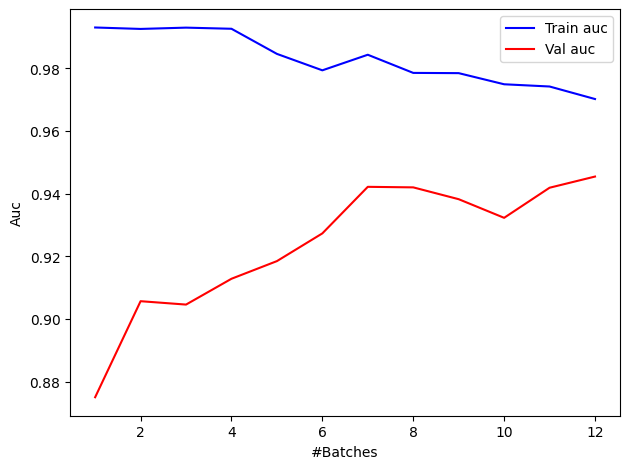

In [30]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

In [32]:
# import optimized pickle written in C for serializing and
# de-serializing a Python object
import _pickle as pkl

# dump to disk
pkl.dump(hashvec, open('output/hashvec.pkl', 'wb'))
pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))

# load from disk
hashvec = pkl.load(open('output/hashvec.pkl', 'rb'))
clf = pkl.load(open('output/clf-sgd.pkl', 'rb'))

df_test = pd.read_csv('./imdb_datasets/test.csv')
print('test auc: %.3f' % roc_auc_score(df_test['sentiment'], \
            clf.predict_proba(hashvec.transform(df_test['review']))[:,1]))


test auc: 0.928
